In [2]:
!rm -r results/
exp_name = input("Enter the experiment name: ")

rm: cannot remove 'results/': No such file or directory
Enter the experiment name: linear_svc


In [3]:
exp_name

'linear_svc'

In [4]:
# !pip install transformer_lens
!python -m spacy download ru_core_news_lg

2023-12-18 11:48:35.718884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 11:48:35.718923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 11:48:35.725994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 11:48:35.746237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 11:48:37.375219: W tensorflow/compiler/tf2

In [5]:
import spacy

model_ru = spacy.load('ru_core_news_lg')

def case_tagger(sent, model):
  tagged_sent = []
  doc = model(sent)
  for token in doc:
    label_list = str(token.morph).split(sep="|")
    case_tag = "DNE"
    for label in label_list:
      if label.split(sep='=')[0] == "Case":
        case_tag = label.split(sep='=')[1]
    tagged_sent.append((token, case_tag))
  return tagged_sent

In [6]:
from transformers import BertTokenizer, BertModel, BertConfig, BertTokenizerFast
import torch

# Load pre-trained BERT model and tokenizer
model_name = 'DeepPavlov/rubert-base-cased'

tokenizer = BertTokenizerFast.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name, output_hidden_states=True)
model = BertModel.from_pretrained(model_name, config=config)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
num_of_lines = 1000
from tqdm import tqdm

all_tokens = []
all_labels = []

with open('russian.txt', 'r') as f:

    lines = f.readlines()[:num_of_lines]
    count = 0
    total = 0
    for line in tqdm(lines):

        line = line.strip()

        case_tags =  [str(case_tag[1]) for case_tag in case_tagger(line, model_ru)]
        tokens = tokenizer.encode(line)
        word_ids = tokenizer(line).word_ids()

        if len(case_tags) != len(set([word_id for word_id in word_ids
                                      if word_id is not None])):
            total += 1
            continue

        labels = []
        for idx in word_ids:
            if idx == None:
                labels.append('DNE')
            else:
                labels.append(case_tags[idx])


        all_tokens.extend(tokens)
        all_labels.extend(labels)

        count += 1
        total += 1

count/total

100%|██████████| 1000/1000 [00:34<00:00, 28.75it/s]


0.682

In [8]:
len(all_tokens) == len(all_labels)

True

In [9]:
from torch.nn.functional import log_softmax
from torch.utils.data import DataLoader

import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

class LanguageModelDataset(Dataset):
    def __init__(self, tokens, labels, max_length=64): # change this back to 128
        self.x = self.split_list(tokens, max_length)[1:-1]
        self.y = self.split_list(labels, max_length)[1:-1]

    # def get_vocab_size(self):
    #     return self.tokenizer.vocab_size

    # def get_block_size(self):
    #     return self.max_length

    def preprocess(self, line: str):
        '''
        To be implemented and varied.
        '''
        return line.strip()

    def split_list(self, input_list, chunk_size):
        return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

CONTEXT_LENGTH = 64
russian_ds =  LanguageModelDataset(all_tokens, all_labels, CONTEXT_LENGTH)
dataloader = DataLoader(russian_ds, batch_size=1, shuffle=False)

In [10]:
len(russian_ds.x) == len(russian_ds.y)

True

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import  RandomUnderSampler



def train_and_evaluate_svm(x, y, df, test_size=0.2, random_state=42, fig_name='fig'):

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=test_size, random_state=random_state)

    rus = RandomUnderSampler(random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    probe = LinearSVC(random_state=random_state)
    probe.fit(X_resampled, y_resampled)

    y_pred = probe.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix of {fig_name}')
    plt.savefig(f'results/{fig_name}.jpg')

    df = append_accuracy_to_dataframe(df, fig_name, y_test, y_pred)

    return accuracy, confusion_mat, df


In [12]:
import pandas as pd

def append_accuracy_to_dataframe(df, model_layer_name, y_test, y_pred):
    class_report = classification_report(y_test, y_pred, output_dict=True)

    new_dict = {}

    for key, value in class_report.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                new_key = f"{key}_{sub_key}"
                new_dict[new_key] = sub_value
        else:
            new_dict[key] = value

    new_row = {'model_layer': model_layer_name, **new_dict}
    df = df.append(new_row, ignore_index=True)
    df.to_csv('results/data.csv')

    return df

In [13]:
!mkdir results

Forward Passes: 100%|██████████| 220/220 [01:00<00:00,  3.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-12-531714cf7598>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
Forward Passes: 100%|██████████| 220/220 [01:06<00:00,  3.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-12-531714cf7598>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
Forward Passes: 100%|██████████| 220/220 [01:02<00:00,  3.50it/s]
/usr/local/lib/python3.10/dist-packa

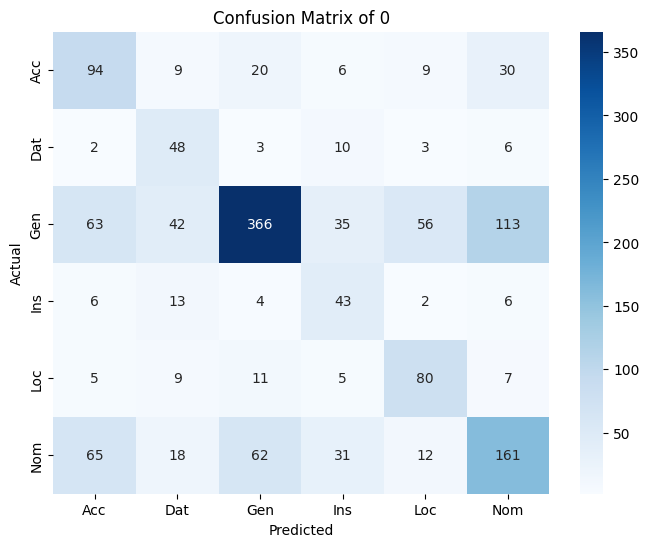

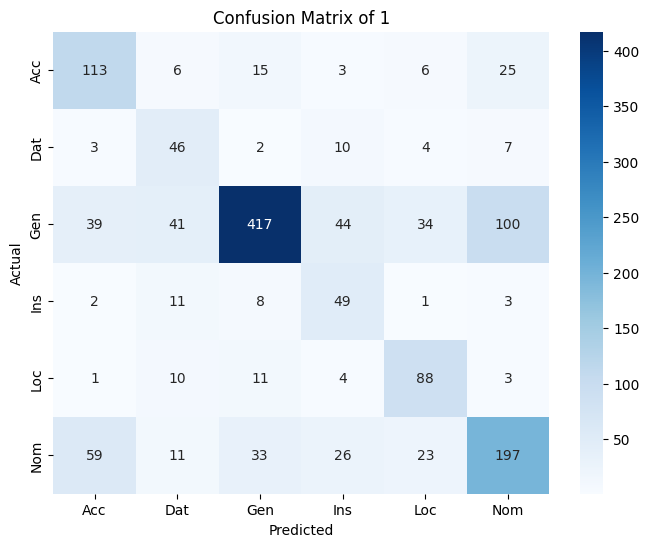

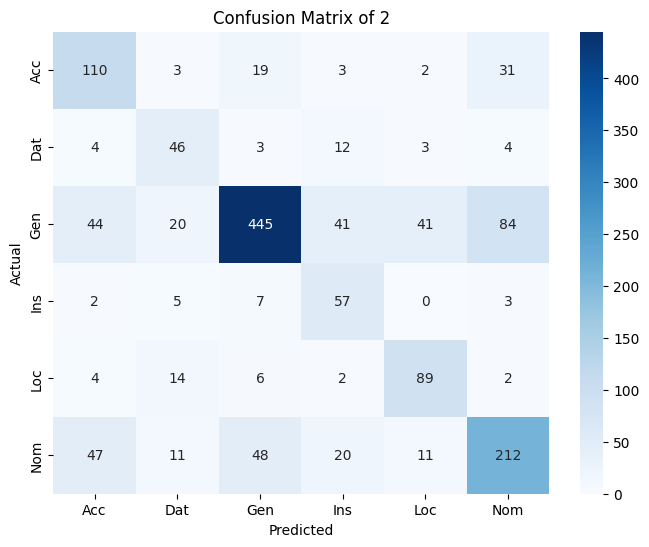

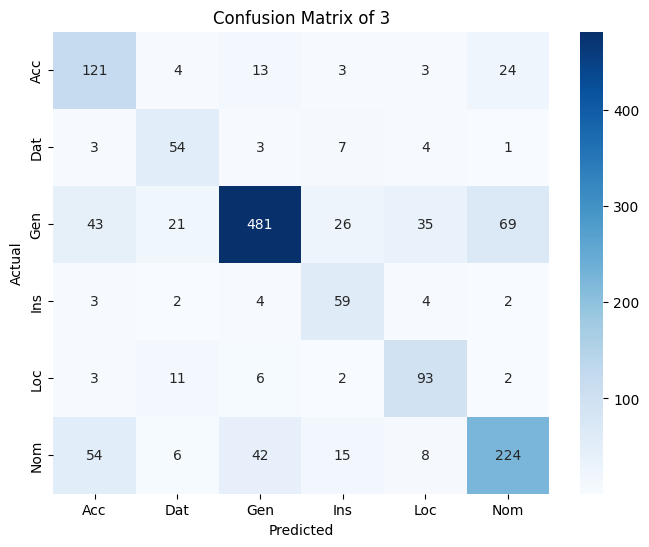

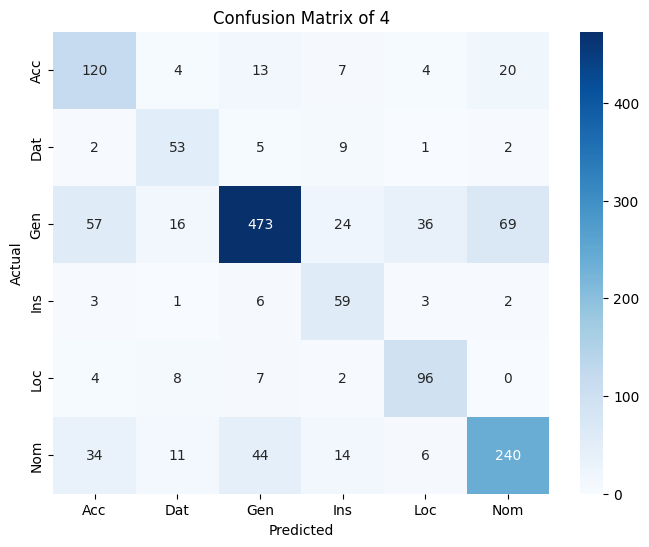

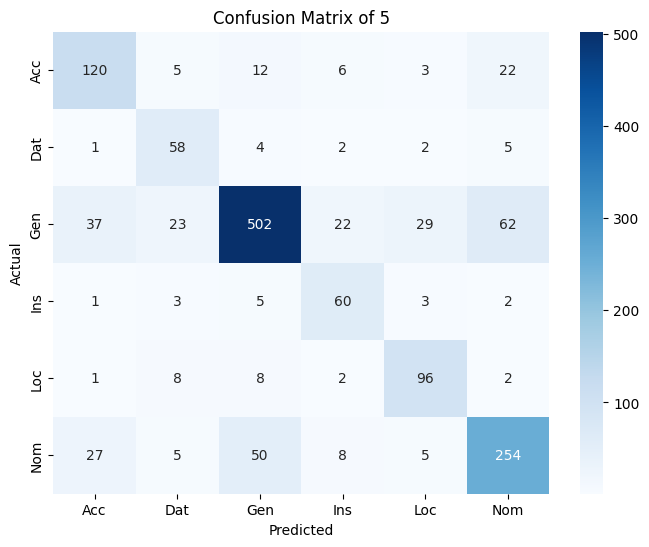

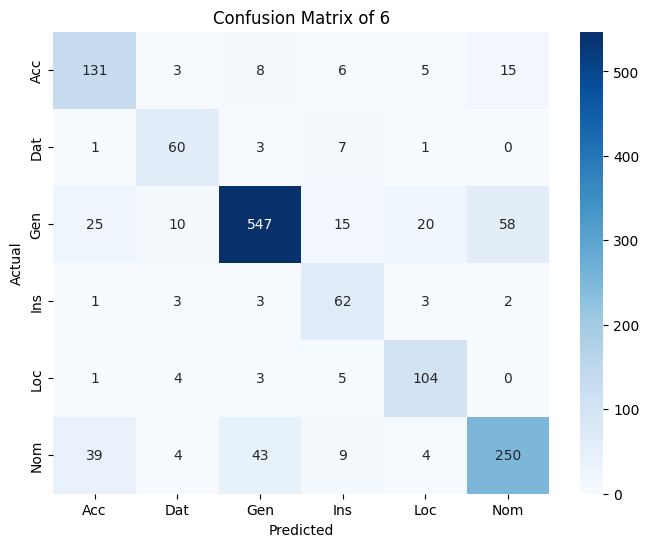

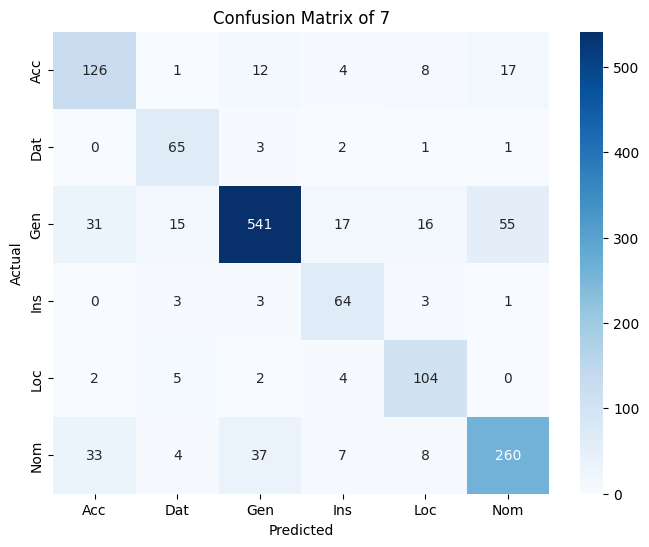

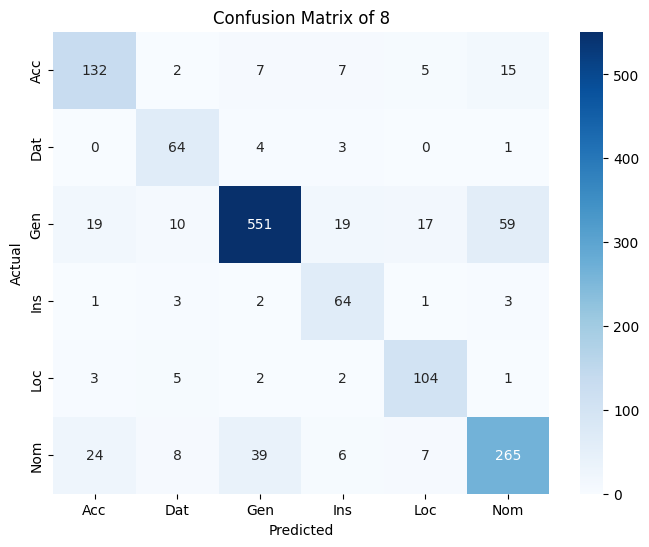

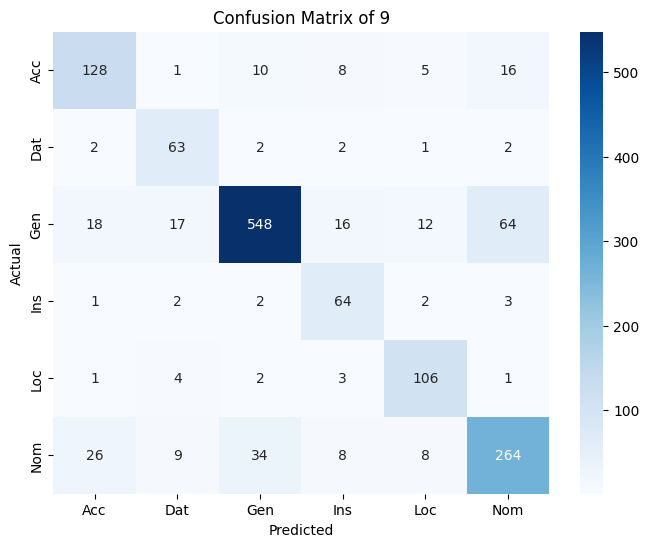

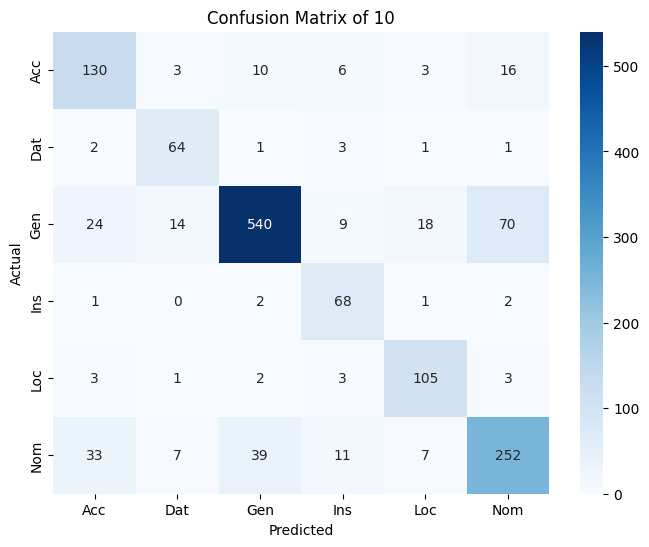

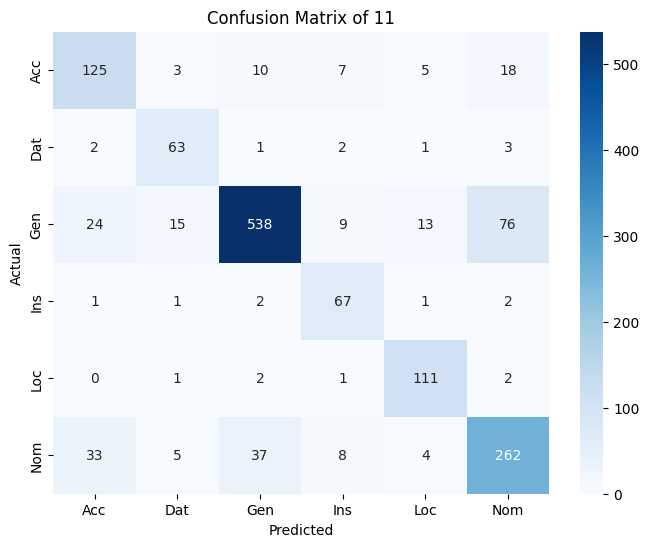

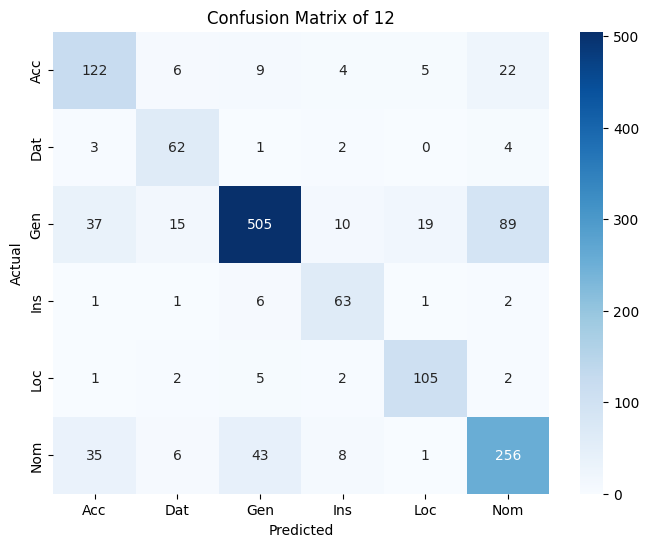

In [14]:
from tqdm import tqdm
import numpy as np

d_embed = 768
df = pd.DataFrame()
for model_component in tqdm(range(13)):
    x, y = [], []
    try:
        with torch.no_grad():

            for batch in tqdm(zip(russian_ds.x, russian_ds.y), total=len(russian_ds.x), desc='Forward Passes'):
                model_input, token_labels = batch
                y.extend(token_labels)
                outputs = model(torch.tensor(model_input).unsqueeze(0))
                activations = outputs['hidden_states'][model_component] # (batch_size, context_length, d_embed)
                x.extend(list(activations.view(-1, d_embed).cpu().numpy()))

            x_npy = np.array(x)
            y_npy = np.array(y)
            indices_to_exclude = list(np.where(y_npy == 'DNE')[0])
            mask = ~np.isin(np.arange(len(y_npy)), indices_to_exclude)
            x_npy = x_npy[mask]
            y_npy = y_npy[mask]

            acc, conf_matrix, df = train_and_evaluate_svm(x_npy, y_npy, df, fig_name=model_component)

    except Exception as e:
        print(e)
        pass

In [15]:
import zipfile
import os

directory_to_zip = "results"

# Creating a zip file with a dynamically generated name
zip_file_name = f"results_{exp_name}.zip"
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f"Zip file '{zip_file_name}' created successfully.")

from google.colab import files
files.download(zip_file_name)

Zip file 'results_linear_svc.zip' created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>